<a href="https://colab.research.google.com/github/juan-villa02/medical_vqa_vlm/blob/main/code/notebooks/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VQA Model - BERT + ResNet18

## Libraries/Dependencies

In [1]:
# PyTorch framework
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.utils as utils
# Image handling
from PIL import Image
from skimage import transform
# Transformers (Hugginface)
from transformers import AutoTokenizer, BertForQuestionAnswering, VisualBertModel, VisualBertForQuestionAnswering, VisualBertConfig
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Extra dependencies
import json
import os
from tqdm import tqdm
import zipfile

In [2]:
# Set training device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Paths & Data Extraction

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path_dir = '.'
path_dir = '/content/drive/MyDrive/TFG Juan Villanueva/databases_qa.zip'

In [5]:
# Data folder
data_folder = './data/'

In [6]:
# ISIC_2016 database (images)
train_ISIC_path = 'databases_qa/ISIC_2016/images/ISBI2016_ISIC_Part3_Training_Data_orig'
test_ISIC_path = 'bases de datos/ISIC_2016/images/ISBI2016_ISIC_Part1_Test_Data_orig'

In [7]:
# Pizarro database (images)
pizarro_path = 'databases_qa/pizarro/images'

In [8]:
# Function to extract databases from the main zip file
def extract_databases(zip_path, extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

In [9]:
# Extract all databases from the main zip file
if path_dir != '.':
  extract_databases(path_dir, data_folder)

In [10]:
# ISIC_2016 images
database1_train_path = os.path.join(data_folder, train_ISIC_path)
database1_test_path = os.path.join(data_folder, test_ISIC_path)

In [11]:
# Pizarro images
# 500 imágenes; Las 46 primeras son más complejas, en cuanto a diagnóstico. (Entrega 1) El resto están más equilibradas (Entrega 2-5)
database2_path = os.path.join(data_folder, pizarro_path)

## VQA Dataset - Images & QA

In [12]:
# Dataset class to load images and questions
class VQADataset(Dataset):
    def __init__(self, data_dir, json_file, tokenizer=None, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.tokenizer = tokenizer

        with open(json_file, 'r') as f:
            self.data = json.load(f)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image_path = os.path.join(self.data_dir, item['image_id'])

        # Ensure the image ID ends with ".jpg"
        if not image_path.endswith(".jpg"):
            image_path += ".jpg"

        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Store questions and answers in two different arrays
        qa_pairs = item['qa_pairs']
        questions = [qa['question'] for qa in qa_pairs]
        answers = [qa['answer'] for qa in qa_pairs]

        return image, questions, answers

In [13]:
pizarroDataset = VQADataset(database2_path,'/content/data/databases_qa/pizarro/qa_pizarro.json')

In [ ]:
#pizarroDataset[10]

## Load pre-trained ResNet18

In [15]:
# Load ResNet-18 model from .pth file
def load_resnet(path, optimizer=None, scheduler=None):
    resnet = models.resnet18()
    # Remove final fully connected layer (we do not want the model to return labels but features)
    resnet.fc = nn.Identity()

    # Load the weights
    state_dict = torch.load(path, map_location=device)['state_dict']

    # Remove unexpected keys if they exist
    unexpected_keys = ['fc.weight', 'fc.bias']
    for key in unexpected_keys:
        if key in state_dict:
            del state_dict[key]

    # Load the weights
    resnet.load_state_dict(state_dict)
    resnet.eval()

    if optimizer is not None:
        optimizer.load_state_dict(torch.load(path)['optimizer'])
    if scheduler is not None:
        scheduler.load_state_dict(torch.load(path)['scheduler'])

    resnet.to(device)

    return resnet, optimizer, scheduler

In [16]:
model_source_path = '/content/drive/MyDrive/TFG Juan Villanueva/codigo diagnostico/bestdiagNet.pth'

In [17]:
resnet, optimizer, scheduler = load_resnet(model_source_path)

In [18]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Image Transformations

In [19]:
class Normalize(object):
    """Normalizes the image by subtracting the mean and dividing by the standard deviations.

    Args:
        mean: The vector containing the means.
        std: The vector containing the standard deviations.
    """

    def __init__(self, mean, std):
        assert len(mean) == len(std), 'Length of mean and std vectors is not the same'
        self.mean = np.array(mean)
        self.std = np.array(std)

    def __call__(self, image):

        image = image.float()  # Convert to float tensor
        image = image / 255.0  # Scale pixel values to the range [0, 1]

        dtype = image.dtype
        mean = torch.as_tensor(self.mean, dtype=dtype, device=image.device)
        std = torch.as_tensor(self.std, dtype=dtype, device=image.device)
        # Avoid division by nearly zero
        std[std < 1e-5] = 1.0
        # Normalize the image
        image = (image - mean[:, None, None]) / std[:, None, None]

        return image

In [20]:
class ToTensor(object):
    """Converts the image ndarray to a tensor."""

    def __call__(self, image):
        # Change the axes
        # numpy image: H x W x C
        # torch image: C x H x W
        image = np.array(image)
        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image)

        return image


In [21]:
class Rescale(object):
    """Rescales the image to a desired size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is the output_size.
            If int, the smaller of the image edges is matched to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        # Convert the PIL image to a NumPy array
        image_np = np.array(image)

        # Get the height and width of the image
        h, w = image_np.shape[:2]

        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        # Resize the image using scikit-image's resize function
        resized_image = transform.resize(image_np, (new_h, new_w))

        # Convert the resized NumPy array back to a PIL image
        resized_image_pil = Image.fromarray((resized_image * 255).astype(np.uint8))

        return resized_image_pil

## Datasets and Dataloaders

In [22]:
# Train ISIC Dataset------------------------------------------------------------
train_dataset_isic = VQADataset(data_dir=database1_train_path,
                           json_file='/content/data/databases_qa/ISIC_2016/qa_ISIC.json',
                           tokenizer=None,
                           transform=transforms.Compose([
                            Rescale((224,224)),
                            ToTensor(),
                            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                            ]))
# Test ISIC Dataset--------------------------------------------------------------
test_dataset_isic = VQADataset(data_dir=database1_test_path,
                           json_file='/content/data/databases_qa/ISIC_2016/qa_ISIC.json',
                           tokenizer=None,
                           transform=transforms.Compose([
                            Rescale((224,224)),
                            ToTensor(),
                            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                            ]))

In [23]:
# Train Pizarro Dataset------------------------------------------------------------
train_dataset_pizarro = VQADataset(data_dir=database2_path,
                           json_file='/content/data/databases_qa/pizarro/qa_pizarro.json',
                           tokenizer=None,
                           transform=transforms.Compose([
                            Rescale((224,380)),
                            ToTensor(),
                            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                            ]))

## Define the all the possible answers within both datasets

In [24]:
# Extract all answers from the dataset
all_answers = [answer for _, _, answers in train_dataset_pizarro for answer in answers]
# Obtain unique answer values
unique_answers = list(set(all_answers))

In [25]:
unique_answers

[' chrysalis is observed.',
 'Yes, subtle peripheral globules are observed.',
 'The peripheral globular pattern is focal conventional.',
 'The histology diagnostic indicates non-atypical stable mole (m).',
 'Yes, clear whitish blue veil is observed.',
 'The histology diagnostic indicates reed nevus (nr).',
 'No homogeneous area without vessels is observed.',
 ' peripheral globules are observed.',
 'The histology diagnostic indicates superficial spreading melanoma (ssm).',
 'Yes, subtle chrysalis is observed.',
 'Yes, subtle negative reticulum is observed.',
 'The histology diagnostic indicates intradermal melanocytic nevus (imn).',
 'No gray regression is observed.',
 'The peripheral globular pattern is .',
 'Yes, clear gray regression is observed.',
 'The lesion is asymmetric on two axes.',
 'The global pattern of the lesion is globular.',
 'Yes, clear and dominant homogeneous area with vessels is observed.',
 'No peripheral globules are observed.',
 'The peripheral globular pattern i

In [26]:
# Create dictionaries id2label and label2id
id2label = {i: label for i, label in enumerate(unique_answers)}
label2id = {label: i for i, label in enumerate(unique_answers)}

In [27]:
id2label

{0: ' chrysalis is observed.',
 1: 'Yes, subtle peripheral globules are observed.',
 2: 'The peripheral globular pattern is focal conventional.',
 3: 'The histology diagnostic indicates non-atypical stable mole (m).',
 4: 'Yes, clear whitish blue veil is observed.',
 5: 'The histology diagnostic indicates reed nevus (nr).',
 6: 'No homogeneous area without vessels is observed.',
 7: ' peripheral globules are observed.',
 8: 'The histology diagnostic indicates superficial spreading melanoma (ssm).',
 9: 'Yes, subtle chrysalis is observed.',
 10: 'Yes, subtle negative reticulum is observed.',
 11: 'The histology diagnostic indicates intradermal melanocytic nevus (imn).',
 12: 'No gray regression is observed.',
 13: 'The peripheral globular pattern is .',
 14: 'Yes, clear gray regression is observed.',
 15: 'The lesion is asymmetric on two axes.',
 16: 'The global pattern of the lesion is globular.',
 17: 'Yes, clear and dominant homogeneous area with vessels is observed.',
 18: 'No perip

In [28]:
# Required tensor with the label IDs
answers_ids_tensor = torch.arange(len(id2label), dtype=torch.float, device=device)
answers_ids_tensor

tensor([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
         24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
         36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
         48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
         60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
         72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
         84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
         96.,  97.,  98.,  99., 100., 101.], device='cuda:0')

In [29]:
# Pizarro dataset
pizarro_dataloader = DataLoader(train_dataset_pizarro, batch_size=5, shuffle=True)
test_isic_dataloader = DataLoader(test_dataset_isic, batch_size=5, shuffle=True)

In [30]:
# Auxiliary function to visualize a batch
def show_batch(sample_batched):
    """Show a batch of images."""

    # Store images, questions and answers
    images_batch, questions_batch, answers_batch = \
            sample_batched[0], sample_batched[1], sample_batched[2]

    # Identify the batch size to define the grid
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    # Generate the grid
    grid = utils.make_grid(images_batch)

    # Convert to numpy and denormalize
    grid = grid.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    grid = std * grid + mean
    grid = np.clip(grid, 0, 1)
    plt.imshow(grid)
    plt.title('Batch from dataloader')
    plt.axis('off')
    plt.show()

0 [('The general silhouette of the lesion is flat.', 'The general silhouette of the lesion is flat.', 'The general silhouette of the lesion is flattened elevated.', 'The general silhouette of the lesion is flat.', 'The general silhouette of the lesion is flat.'), ('The general silhouette of the lesion is flat.', 'The general silhouette of the lesion is flat.', 'The general silhouette of the lesion is flattened elevated.', 'The general silhouette of the lesion is flat.', 'The general silhouette of the lesion is flat.'), ('The general silhouette of the lesion is flat.', 'The general silhouette of the lesion is flat.', 'The general silhouette of the lesion is flattened elevated.', 'The general silhouette of the lesion is flat.', 'The general silhouette of the lesion is flat.'), ('The general silhouette of the lesion is flat.', 'The general silhouette of the lesion is flat.', 'The general silhouette of the lesion is flattened elevated.', 'The general silhouette of the lesion is flat.', 'Th

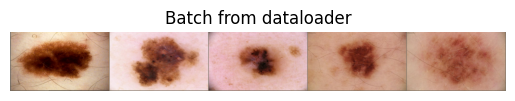

1 [('The general silhouette of the lesion is flat.', 'The general silhouette of the lesion is flat.', 'The general silhouette of the lesion is flattened elevated.', 'The general silhouette of the lesion is flat.', 'The general silhouette of the lesion is flat.'), ('The general silhouette of the lesion is flat.', 'The general silhouette of the lesion is flat.', 'The general silhouette of the lesion is flattened elevated.', 'The general silhouette of the lesion is flat.', 'The general silhouette of the lesion is flat.'), ('The general silhouette of the lesion is flat.', 'The general silhouette of the lesion is flat.', 'The general silhouette of the lesion is flattened elevated.', 'The general silhouette of the lesion is flat.', 'The general silhouette of the lesion is flat.'), ('The general silhouette of the lesion is flat.', 'The general silhouette of the lesion is flat.', 'The general silhouette of the lesion is flattened elevated.', 'The general silhouette of the lesion is flat.', 'Th

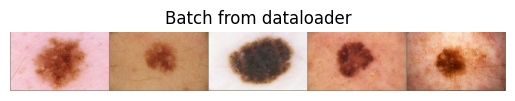

In [31]:
# Iterate over the dataloader and visualize batches
for i_batch, sample_batched in enumerate(pizarro_dataloader):
    print(i_batch, sample_batched[2])
    show_batch(sample_batched)

    # Show only the data of the 3rd batch and stop.
    if i_batch == 1:
        break

## Image Feature Extraction

In [32]:
def extract_image_features(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    num_samples = len(dataloader.dataset)

    # Get the output shape of the model
    with torch.no_grad():
        sample_input = next(iter(dataloader))[0].to(next(model.parameters()).device)
        output_shape = model(sample_input).shape[1:]

    # Calculate the total number of features
    num_features = np.prod(output_shape)

    features = np.zeros((num_samples, num_features), dtype=np.float32)
    sample_idx = 0

    with torch.no_grad():
        for sample in dataloader:
            # Get images
            inputs = sample[0].to(device).float()

            # Forward pass
            outputs = model(inputs)

            # Flatten the output tensor
            outputs_flat = outputs.view(outputs.size(0), -1)

            # Store features
            batch_size = inputs.size(0)
            features[sample_idx:sample_idx + batch_size, :] = outputs_flat.cpu().numpy()
            sample_idx += batch_size

    return torch.tensor(features, device=device)

In [33]:
# features_pizarro = extract_image_features(resnet, pizarro_dataloader)

In [34]:
# features_pizarro

In [37]:
# Function to print GPU memory usage
def print_gpu_memory():
    print(f"Memory allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Memory reserved: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

## VQA Model Creation

In [75]:
class VQAModel(nn.Module):
    def __init__(self, resnet, vlm, tokenizer):
        super(VQAModel, self).__init__()

        # Pre-trained ResNet model
        self.resnet = resnet
        # Vision Language Model
        self.vlm = vlm
        # Tokenizer
        self.tokenizer = tokenizer
        # Freeze parameters of the ResNet model
        for param in self.resnet.parameters():
            param.requires_grad = False

    def forward(self, image_features, question, labels_idxs=None, training=False):

        # image_features -> array with visual features for the specific image
        # question -> individual question within the image batch
        # labels_idx -> tensor with shape (0, ..., num_labels-1)
        # training; boolean to determine the mode (train/evaluation)


        # Prepare image inputs
        visual_token_type_ids = torch.ones(image_features.shape[0], dtype=torch.long, device=device)
        visual_attention_mask = torch.ones(image_features.shape[0], dtype=torch.float, device=device)

        # Tokenize question
        tokenized_question = self.tokenizer(question,
                                            return_token_type_ids=True,
                                            return_attention_mask=True,
                                            add_special_tokens=True,
                                            return_tensors='pt')

        # Input for the VLM model (refer to VisualBert to understand the shapes)
        input_dict = {
            "visual_embeds": image_features.unsqueeze(0),
            "visual_token_type_ids": visual_token_type_ids.unsqueeze(0),
            "visual_attention_mask": visual_attention_mask.unsqueeze(0),
            "input_ids": tokenized_question['input_ids'].to(device),
            "token_type_ids": tokenized_question['token_type_ids'].to(device),
            "attention_mask": tokenized_question['attention_mask'].to(device),
        }

        # Training mode: track gradients
        if training:

            output = self.vlm(**input_dict, labels=labels_idxs)
            logits = output.logits
            loss = output.loss

            del output

        # Evaluation mode: no gradients
        else:
            with torch.no_grad():
                output = self.vlm(**input_dict)
                logits = output.logits

        # # Check for memory usage
        # print_gpu_memory()

        return logits, loss

### Define LLM & Tokenizer

In [76]:
# Pre-trained base case for VQA provided in documentation
# tokenizer = AutoTokenizer.from_pretrained("deepset/bert-base-cased-squad2")
# bertModel = BertForQuestionAnswering.from_pretrained("deepset/bert-base-cased-squad2")
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
# Modify the visual embedding config so that size of the features matches
configuration = VisualBertConfig.from_pretrained("uclanlp/visualbert-vqa",
                                                 visual_embedding_dim=512,
                                                 num_labels=answers_ids_tensor.shape[0])
visualBert = VisualBertForQuestionAnswering(configuration)

## Training Loop

In [105]:
# Create the VQA Model and pass it to the GPU
vqa_model = VQAModel(resnet, visualBert, tokenizer)

In [106]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vqa_model.to(device)

VQAModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [94]:
# Define hyperparameters
learning_rate = 1e-4
num_epochs = 4

In [107]:
# Define optimizer
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, vqa_model.parameters()), lr=learning_rate)

In [96]:
# Extract all image features for the dataloader
with torch.no_grad():
    image_features = extract_image_features(vqa_model.resnet, pizarro_dataloader)

In [97]:
image_features

tensor([[0.0064, 0.6662, 0.7648,  ..., 1.0083, 0.7114, 0.4031],
        [0.5917, 0.7600, 0.5522,  ..., 0.6599, 0.0977, 1.0333],
        [0.8228, 0.3287, 0.1375,  ..., 0.6152, 0.2585, 0.5332],
        ...,
        [0.2393, 1.0409, 0.2324,  ..., 1.1711, 0.7257, 0.7865],
        [0.3203, 1.4047, 0.6549,  ..., 0.4143, 1.7499, 0.6852],
        [0.2599, 0.1020, 0.2589,  ..., 0.4287, 0.4862, 0.9428]],
       device='cuda:0')

In [ ]:
# Set the model in training mode
vqa_model.train()
# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0
    num_batches = 0
    text_results = []
    for images, questions, answers in tqdm(pizarro_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):

        # Track batch loss
        batch_loss = 0.0

        # Transpose questions and answers
        questions = np.transpose(questions)
        answers = np.transpose(answers)
        # Store shape for iteration
        num_images, num_questions_per_image = np.shape(questions)

        # Iterate over all questions for each image
        for image_idx in range(num_images):
          for question_idx in range(num_questions_per_image):

            # Avoid using previous gradients
            optimizer.zero_grad()

            #Forward pass
            outputs, loss = vqa_model(image_features[image_idx], questions[image_idx,question_idx], answers_ids_tensor, training=True)

            # Backpropagation
            loss.backward()
            optimizer.step()

            batch_loss += loss.item() / (num_images * num_questions_per_image)

            # Store the text predicted answers, the ground truth and corresponding question
            probabilities = torch.softmax(outputs, dim=-1)
            pred_idx = torch.argmax(probabilities, dim=-1)
            pred_answer = id2label[pred_idx.item()]

            text_results.append({
                  "Image ID": image_idx,
                  "Question": questions[image_idx,question_idx],
                  "Ground Truth": answers[image_idx, question_idx],
                  "Prediction": pred_answer
                  })

            # Remove unnecessary tensors from memory
            del loss
            del outputs

        # Print batch loss
        print(f"Batch Loss: {batch_loss}")

        # Accumulate the total loss and num of batches
        total_loss += batch_loss
        num_batches += 1

    # Aaverage training loss for the epoch
    avg_loss = total_loss / num_batches
    print(f"Epoch {epoch + 1}, Average Loss: {avg_loss}")

    # Save trained model after each epoch
    torch.save(vqa_model.state_dict(), f'trained_vqa_model_epoch{epoch+1}.pth')

Epoch 1/4:   1%|          | 1/100 [01:15<2:04:40, 75.56s/batch]

Batch Loss: 44035.17403409089


Epoch 1/4:   2%|▏         | 2/100 [02:31<2:03:49, 75.81s/batch]

Batch Loss: 44034.60358664771


Epoch 1/4:   3%|▎         | 3/100 [03:47<2:02:37, 75.85s/batch]

Batch Loss: 44033.31530539769


Epoch 1/4:   4%|▍         | 4/100 [05:03<2:01:24, 75.88s/batch]

Batch Loss: 44032.18056107949


Epoch 1/4:   5%|▌         | 5/100 [06:19<2:00:09, 75.89s/batch]

Batch Loss: 44031.80078835227


Epoch 1/4:   6%|▌         | 6/100 [07:35<1:58:54, 75.90s/batch]

Batch Loss: 44030.607223011364


Epoch 1/4:   7%|▋         | 7/100 [08:51<1:57:36, 75.88s/batch]

Batch Loss: 44029.74075994316


Epoch 1/4:   8%|▊         | 8/100 [10:06<1:56:22, 75.90s/batch]

Batch Loss: 44029.05699573864


Epoch 1/4:   9%|▉         | 9/100 [11:22<1:55:09, 75.93s/batch]

Batch Loss: 44028.33013494319


Epoch 1/4:  10%|█         | 10/100 [12:38<1:53:51, 75.91s/batch]

Batch Loss: 44027.868586647724


Epoch 1/4:  11%|█         | 11/100 [13:54<1:52:35, 75.90s/batch]

Batch Loss: 44027.37667613636


Epoch 1/4:  12%|█▏        | 12/100 [15:10<1:51:21, 75.92s/batch]

Batch Loss: 44027.95207386367


Epoch 1/4:  13%|█▎        | 13/100 [16:26<1:50:04, 75.91s/batch]

Batch Loss: 44027.319154829514


Epoch 1/4:  14%|█▍        | 14/100 [17:42<1:48:53, 75.97s/batch]

Batch Loss: 44026.70397727268


In [ ]:
# predictions = []
# for image_idx in range(len(outputs)):
#   image_answers = []
#   for output in outputs[image_idx]:
#       logits = output.logits
#       probabilities = torch.softmax(logits, dim=-1)  # Apply softmax along the last dimension
#       pred_index = torch.argmax(probabilities, dim=-1)  # Get the index of the maximum probability
#       pred_label = id2label[pred_index.item()]
#       image_answers.append(pred_label)
#   predictions.append(image_answers)
# predictions

In [ ]:
# for param in vqa_model.parameters():
#       print(param.grad)